In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import layers

import matplotlib.pyplot as plt
import numpy as np
import random

# Setting seeds for reproducibility.
SEED = 42
keras.utils.set_random_seed(SEED)

2025-05-28 07:58:34.267813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748419114.480426      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748419114.540948      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
# DATA
BUFFER_SIZE = 1024
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 15

# AUGMENTATION
IMAGE_SIZE = 96  # We will resize input images to this size.
PATCH_SIZE = 32 # Size of the patches to be extracted from the input images.
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75  # We have found 75% masking to give us the best results.

# ENCODER and DECODER
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2  # The decoder is lightweight but should be reasonably deep for reconstruction.
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

In [3]:
import os
import tensorflow as tf
import numpy as np

# =======================================
# CONFIGS
# =======================================
DATASET_PATH = "/kaggle/input/ssl-dataset/ssl_dataset"
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE
IMAGE_SIZE = 224

# Select 10 classes
selected_classes = [
    "n01440764", "n01443537", "n01514859", "n01537544", "n01601694",
    "n01614925", "n01622779", "n01630670", "n01644900", "n01664065"
]
class_to_label = {cls: idx for idx, cls in enumerate(selected_classes)}

# =======================================
# FUNCTIONS
# =======================================
def get_image_paths_and_labels(root_dirs, class_list):
    image_paths, labels = [], []
    for class_name in class_list:
        for root_dir in root_dirs:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.exists(class_dir):
                continue
            for fname in os.listdir(class_dir):
                if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                    image_paths.append(os.path.join(class_dir, fname))
                    labels.append(class_to_label[class_name])
    return image_paths, labels

def decode_and_resize(filename, label, img_size=(IMAGE_SIZE, IMAGE_SIZE)):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def prepare_dataset(paths, labels, training=False):
    path_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(paths, dtype=tf.string))
    label_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(labels, dtype=tf.int64))
    ds = tf.data.Dataset.zip((path_ds, label_ds))
    ds = ds.map(lambda x, y: decode_and_resize(x, y), num_parallel_calls=AUTO)
    if training:
        ds = ds.shuffle(1024)
    return ds.batch(BATCH_SIZE).prefetch(AUTO)

# =======================================
# LOAD DATA
# =======================================
train_dirs = [
    os.path.join(DATASET_PATH, "train.X1"),
    os.path.join(DATASET_PATH, "train.X2"),
    os.path.join(DATASET_PATH, "train.X3"),
    os.path.join(DATASET_PATH, "train.X4")
]

val_dir = os.path.join(DATASET_PATH, "val.X")  # Corrected validation folder name

# Get image paths and labels for training
train_paths, train_labels = get_image_paths_and_labels(train_dirs, selected_classes)

# Get image paths and labels for validation + test split
val_paths, val_labels = get_image_paths_and_labels([val_dir], selected_classes)

# Shuffle val_paths & val_labels together before split (important!)
val_data = list(zip(val_paths, val_labels))
np.random.shuffle(val_data)
val_paths, val_labels = zip(*val_data) if val_data else ([], [])

# Split val into val/test (50%-50%)
val_count = len(val_paths)
val_split_idx = val_count // 2
val_ds_paths = val_paths[:val_split_idx]
val_ds_labels = val_labels[:val_split_idx]
test_ds_paths = val_paths[val_split_idx:]
test_ds_labels = val_labels[val_split_idx:]

# =======================================
# CREATE DATASETS
# =======================================
train_ds = prepare_dataset(train_paths, train_labels, training=True)
val_ds = prepare_dataset(val_ds_paths, val_ds_labels)
test_ds = prepare_dataset(test_ds_paths, test_ds_labels)

# =======================================
# OPTIONAL: Convert datasets to numpy arrays (like CIFAR-10)
# =======================================
def ds_to_numpy(dataset):
    x_list, y_list = [], []
    for x, y in dataset.unbatch():
        x_list.append(x.numpy())
        y_list.append(y.numpy())
    return np.array(x_list), np.array(y_list)

x_train, y_train = ds_to_numpy(train_ds)
x_val, y_val = ds_to_numpy(val_ds)
x_test, y_test = ds_to_numpy(test_ds)

# =======================================
# PRINT COUNTS
# =======================================
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")


I0000 00:00:1748419148.143164      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748419148.143912      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Training samples: 13000
Validation samples: 250
Testing samples: 250


In [8]:
import os
import tensorflow as tf
import numpy as np

# =======================================
# CONFIGS
# =======================================
DATASET_PATH = "/kaggle/input/ssl-dataset/ssl_dataset"
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE
IMAGE_SIZE = 224

# Select 10 classes
selected_classes = [
    "n01440764", "n01443537", "n01514859", "n01537544", "n01601694",
    "n01614925", "n01622779", "n01630670", "n01644900", "n01664065"
]
class_to_label = {cls: idx for idx, cls in enumerate(selected_classes)}

# =======================================
# FUNCTIONS
# =======================================
def get_image_paths_and_labels(root_dirs, class_list):
    image_paths, labels = [], []
    for class_name in class_list:
        for root_dir in root_dirs:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.exists(class_dir):
                continue
            for fname in os.listdir(class_dir):
                if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                    image_paths.append(os.path.join(class_dir, fname))
                    labels.append(class_to_label[class_name])
    return image_paths, labels

def decode_and_resize(filename, label, img_size=(IMAGE_SIZE, IMAGE_SIZE)):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def prepare_dataset(paths, labels, training=False):
    path_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(paths, dtype=tf.string))
    label_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(labels, dtype=tf.int64))
    ds = tf.data.Dataset.zip((path_ds, label_ds))
    ds = ds.map(lambda x, y: decode_and_resize(x, y), num_parallel_calls=AUTO)
    if training:
        ds = ds.shuffle(1024)
    return ds.batch(BATCH_SIZE).prefetch(AUTO)

# =======================================
# LOAD DATA
# =======================================
train_dirs = [
    os.path.join(DATASET_PATH, "train.X1"),
    os.path.join(DATASET_PATH, "train.X2"),
    os.path.join(DATASET_PATH, "train.X3"),
    os.path.join(DATASET_PATH, "train.X4")
]

val_dir = os.path.join(DATASET_PATH, "val.X")  # Corrected validation folder name

# Get image paths and labels for training
train_paths, train_labels = get_image_paths_and_labels(train_dirs, selected_classes)

# Get image paths and labels for validation + test split
val_paths, val_labels = get_image_paths_and_labels([val_dir], selected_classes)

# Shuffle val_paths & val_labels together before split (important!)
val_data = list(zip(val_paths, val_labels))
np.random.shuffle(val_data)
val_paths, val_labels = zip(*val_data) if val_data else ([], [])

# Split val into val/test (50%-50%)
val_count = len(val_paths)
val_split_idx = val_count // 2
val_ds_paths = val_paths[:val_split_idx]
val_ds_labels = val_labels[:val_split_idx]
test_ds_paths = val_paths[val_split_idx:]
test_ds_labels = val_labels[val_split_idx:]

# =======================================
# CREATE DATASETS
# =======================================
train_ds = prepare_dataset(train_paths, train_labels, training=True)
val_ds = prepare_dataset(val_ds_paths, val_ds_labels)
test_ds = prepare_dataset(test_ds_paths, test_ds_labels)

# =======================================
# OPTIONAL: Convert datasets to numpy arrays (like CIFAR-10)
# =======================================
def ds_to_numpy(dataset):
    x_list, y_list = [], []
    for x, y in dataset.unbatch():
        x_list.append(x.numpy())
        y_list.append(y.numpy())
    return np.array(x_list), np.array(y_list)

x_train, y_train = ds_to_numpy(train_ds)
x_val, y_val = ds_to_numpy(val_ds)
x_test, y_test = ds_to_numpy(test_ds)

# =======================================
# PRINT COUNTS
# =======================================
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")


Training samples: 13000
Validation samples: 250
Testing samples: 250


In [9]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        ],
        name="test_data_augmentation",
    )
    return model


In [10]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        # Extract patches
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        batch_size = tf.shape(images)[0]
        patch_h = tf.shape(patches)[1]
        patch_w = tf.shape(patches)[2]
        patch_dim = patches.shape[-1]
        # Flatten to (batch, num_patches, patch_dim)
        patches = tf.reshape(patches, [batch_size, patch_h * patch_w, patch_dim])
        return patches
    def show_patched_image(self, images, patches):
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")
    
        # Original Image
        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.axis("off")
        plt.title("Original")
        plt.show()
    
        # Patches
        num_patches = patches.shape[1]
        n = int(np.sqrt(num_patches))
    
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 3))
            patch_img = tf.clip_by_value(patch_img, 0.0, 1.0)
            plt.imshow(patch_img)
            plt.axis("off")
        plt.tight_layout()
        plt.show()
        return idx
    def reconstruct_from_patch(self, patch):
        num_patches = tf.shape(patch)[0]
        n = tf.cast(tf.math.sqrt(tf.cast(num_patches, tf.float32)), tf.int32)
    
        patch = tf.reshape(patch, (n, n, self.patch_size, self.patch_size, 3))
    
        # Rearrange patches into rows and columns
        rows = []
        for i in range(n):
            row = tf.concat([patch[i, j] for j in range(n)], axis=1)
            rows.append(row)
    
        image = tf.concat(rows, axis=0)
        return image



Index selected: 25.


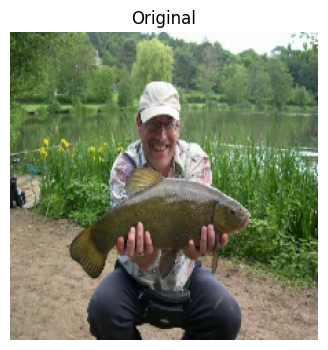

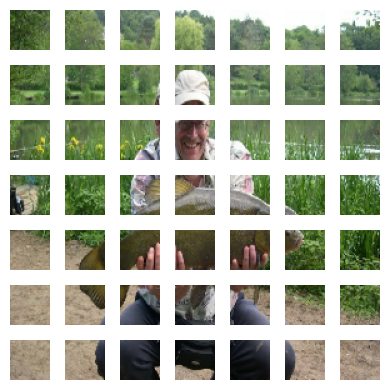

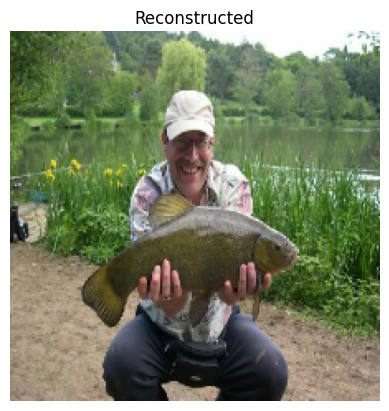

In [12]:

patch_layer = Patches(patch_size=32)  # Try 32, 56, or 112
patches = patch_layer(images)

idx = patch_layer.show_patched_image(images, patches)

# Reconstruct and view
reconstructed = patch_layer.reconstruct_from_patch(patches[idx])
plt.imshow(tf.clip_by_value(reconstructed, 0.0, 1.0))
plt.axis("off")
plt.title("Reconstructed")
plt.show()


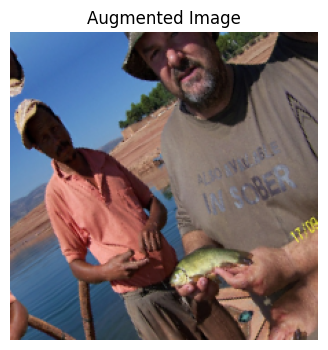

Shape: (224, 224, 3)
Dtype: <dtype: 'float32'>
Min pixel value: 0.0002540648
Max pixel value: 0.99518025
Pixel range (should be 0.0–1.0): 0.0002540648 - 0.99518025
Image tensor summary:
[[[0.38731328 0.576169   0.7724001 ]
  [0.387654   0.5776125  0.7794523 ]
  [0.3875368  0.5804892  0.77691036]
  ...
  [0.09915959 0.05246155 0.02909685]
  [0.11288486 0.0603994  0.04410572]
  [0.13791987 0.08129627 0.06138979]]

 [[0.38639536 0.5749469  0.77517545]
  [0.3848632  0.57379043 0.7673652 ]
  [0.3819043  0.5770507  0.7714909 ]
  ...
  [0.14014542 0.08521435 0.0575538 ]
  [0.14378433 0.08502424 0.06322766]
  [0.14583342 0.08705942 0.06264692]]

 [[0.38772938 0.57858855 0.77211094]
  [0.38526762 0.5734784  0.77160126]
  [0.37871206 0.57296216 0.7713343 ]
  ...
  [0.1582641  0.10677513 0.07529489]
  [0.15271491 0.09671829 0.06539768]
  [0.17271243 0.10914258 0.08103411]]

 ...

 [[0.6651227  0.42425352 0.3614748 ]
  [0.5997563  0.35274568 0.2889126 ]
  [0.5989623  0.35751468 0.29477614]
  ...
 

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Get a batch of images
image_batch = next(iter(train_ds))
images, labels = image_batch

# Define augmentation model
def get_train_augmentation_model():
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
       
        # NO resizing or cropping!
    ])

augmentation_model = get_train_augmentation_model()

# Augment the image
augmented_images = augmentation_model(images)
aug_img = augmented_images[0]  # Take one image

# Show image
plt.figure(figsize=(4, 4))
plt.imshow(tf.clip_by_value(aug_img, 0.0, 1.0))
plt.axis("off")
plt.title("Augmented Image")
plt.show()

# Print debug info
print("Shape:", aug_img.shape)
print("Dtype:", aug_img.dtype)
print("Min pixel value:", tf.reduce_min(aug_img).numpy())
print("Max pixel value:", tf.reduce_max(aug_img).numpy())
print("Pixel range (should be 0.0–1.0):", tf.reduce_min(aug_img).numpy(), "-", tf.reduce_max(aug_img).numpy())
print("Image tensor summary:")
print(aug_img.numpy())


Index selected: 117.


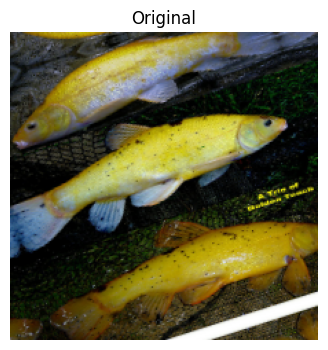

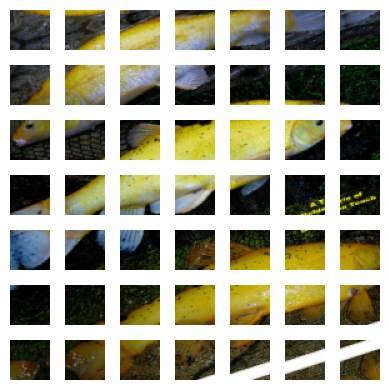

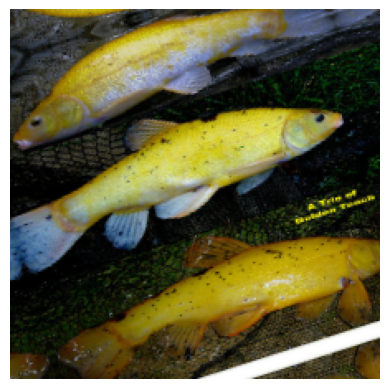

In [13]:
# Get a batch of images.
image_batch = next(iter(train_ds))

# Augment the images.
images, labels = image_batch 
augmentation_model = get_train_augmentation_model()
augmented_images = augmentation_model(images)
aug_image = augmented_images[0]

# Define the patch layer.
patch_layer = Patches(32)

# Get the patches from the batched images.
patches = patch_layer(images=augmented_images)

# Now pass the images and the corresponding patches
# to the `show_patched_image` method.
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches)

# Chose the same chose image and try reconstructing the patches
# into the original image.
reconstructed = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(reconstructed)
plt.axis("off")
plt.show()

In [54]:
#masking
class PatchEncoder(layers.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        # This is a trainable mask token initialized randomly from a normal
        # distribution.
        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape

        # Create the projection layer for the patches.
        self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )

        # Number of patches that will be masked.
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        # Get the positional embeddings.
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)

        # Embed the patches.
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )  # (B, num_patches, projection_dim)

        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            # The encoder input is the unmasked patch embeddings. Here we gather
            # all the patches that should be unmasked.
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them
            # for the decoder.
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)

            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            # Get the masked embeddings for the tokens.
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )

    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        # Choose a random patch and it corresponding unmask index.
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch.
        new_patch = np.zeros_like(patch)

        # Iterate of the new_patch and plug the unmasked patches.
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

In [14]:
#masking
class PatchEncoder(layers.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        num_mask_patches=9,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.num_mask = num_mask_patches
        self.downstream = downstream

        # This is a trainable mask token initialized randomly from a normal
        # distribution.
        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape

        # Create the projection layer for the patches.
        self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )

    def call(self, patches):
        # Get the positional embeddings.
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)

        # Embed the patches.
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )  # (B, num_patches, projection_dim)

        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            # The encoder input is the unmasked patch embeddings. Here we gather
            # all the patches that should be unmasked.
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them
            # for the decoder.
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)

            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            # Get the masked embeddings for the tokens.
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )

    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        # Choose a random patch and it corresponding unmask index.
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch.
        new_patch = np.zeros_like(patch)

        # Iterate of the new_patch and plug the unmasked patches.
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

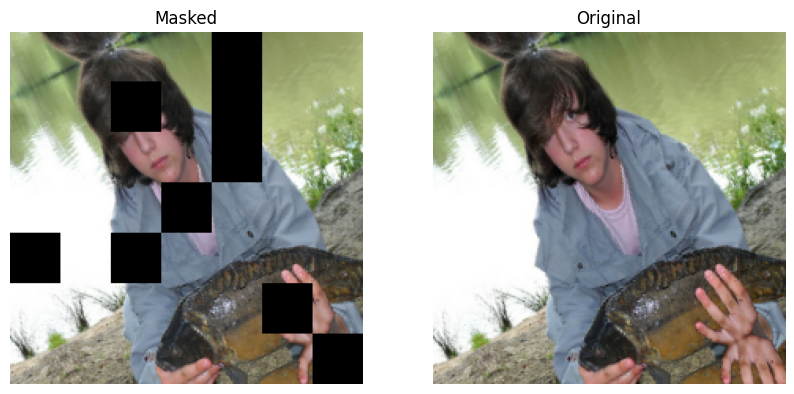

In [15]:
#visualize 
# Create the patch encoder layer.
patch_encoder = PatchEncoder()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)


# Show a maksed patch image.
new_patch, random_index = patch_encoder.generate_masked_image(patches, unmask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmented_images[random_index]
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Original")
plt.show()

In [ ]:
# model MAE from here 

In [16]:
#fully connected layer
def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x
    

In [17]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")

In [18]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.GlobalAveragePooling1D()(x)
    pre_final = layers.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)

    outputs = layers.Reshape((image_size, image_size, 3))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")


In [70]:
#original
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder
    def call(self, inputs):
    # This method won't be used, but it's required for the model to compile and build.
        return inputs

    def calculate_loss(self, images, test=False):
        # Augment the input images.
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        # Patch the augmented images.
        patches = self.patch_layer(augmented_images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compute_loss(y=loss_patch, y_pred=loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, data):
        images, labels = data
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)
        
        train_vars = (
            self.train_augmentation_model.trainable_variables +
            self.patch_layer.trainable_variables +
            self.patch_encoder.trainable_variables +
            self.encoder.trainable_variables +
            self.decoder.trainable_variables
        )
        grads = tape.gradient(total_loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
    
        results = {}
        for metric in self.metrics:
            metric.update_state(loss_patch, loss_output)
            results[metric.name] = metric.result()
        return results
    
    def test_step(self, data):
        images, labels = data
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)
    
        results = {}
        for metric in self.metrics:
            metric.update_state(loss_patch, loss_output)
            results[metric.name] = metric.result()
        return results
        
    


In [19]:
#new
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder
    def call(self, inputs):
    # This method won't be used, but it's required for the model to compile and build.
        return inputs

    def calculate_loss(self, images, test=False):
        # Augment the input images.
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        # Patch the augmented images.
        patches = self.patch_layer(augmented_images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compute_loss(y=loss_patch, y_pred=loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, data):
        images , _ = data
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)
        
        train_vars = (
            self.train_augmentation_model.trainable_variables +
            self.patch_layer.trainable_variables +
            self.patch_encoder.trainable_variables +
            self.encoder.trainable_variables +
            self.decoder.trainable_variables
        )
        grads = tape.gradient(total_loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
    
        results = {}
        for metric in self.metrics:
            metric.update_state(loss_patch, loss_output)
            results[metric.name] = metric.result()
        return results
    
    def test_step(self, data):
        images , _ = data
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)
    
        results = {}
        for metric in self.metrics:
            metric.update_state(loss_patch, loss_output)
            results[metric.name] = metric.result()
        return results
        
    


In [ ]:
# initialize model

In [20]:
train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches(patch_size = 32)
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

In [21]:
#Visualization callback
# Taking a batch of test inputs to measure model's progress.
test_images = next(iter(test_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_image)
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(masked_image)
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image)
            ax[2].set_title(f"Resonstructed: {epoch:03d}")

            plt.show()
            plt.close()

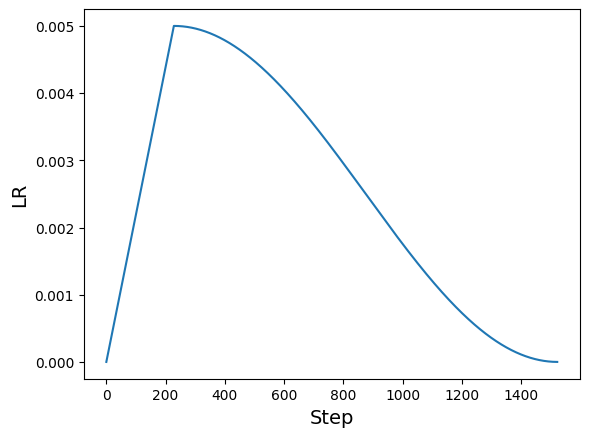

In [22]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.


class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]

In [23]:
# Check the structure of train_ds
for batch in train_ds.take(1):
    print("train_ds sample:", batch)
    break

# Check the structure of val_ds
for batch in val_ds.take(1):
    print("val_ds sample:", batch)
    break


train_ds sample: (<tf.Tensor: shape=(128, 224, 224, 3), dtype=float32, numpy=
array([[[[0.3146246 , 0.3552177 , 0.2601103 ],
         [0.5140919 , 0.6235757 , 0.44379503],
         [0.37445852, 0.44228625, 0.31799722],
         ...,
         [0.26682997, 0.3385504 , 0.21254914],
         [0.3634378 , 0.49506965, 0.35379532],
         [0.2404567 , 0.283328  , 0.22409616]],

        [[0.26304337, 0.28777263, 0.30447307],
         [0.266012  , 0.40832704, 0.1641694 ],
         [0.39724645, 0.5135436 , 0.3069103 ],
         ...,
         [0.33434036, 0.39279115, 0.29226577],
         [0.3730557 , 0.47883824, 0.34097233],
         [0.36835042, 0.49731702, 0.3111864 ]],

        [[0.2667605 , 0.38864923, 0.20669582],
         [0.24602853, 0.20427121, 0.23722184],
         [0.27458417, 0.27764675, 0.26232806],
         ...,
         [0.18557039, 0.29933888, 0.17108239],
         [0.20859553, 0.25910062, 0.1614417 ],
         [0.19238216, 0.25902054, 0.16340816]],

        ...,

        [[0.37

In [ ]:
train_ds = train_ds.map(lambda x, y: x)
val_ds = val_ds.map(lambda x, y: x)
test_ds = test_ds.map(lambda x, y: x)


In [ ]:
for batch in train_ds.take(1):
    print(batch)
    break


Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - mae: 0.2239 - loss: 0.4111

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_89
Received: inputs=('Tensor(shape=(128, 224, 224, 3))', 'Tensor(shape=(128,))')
  warnings.warn(msg)



Idx chosen: 18


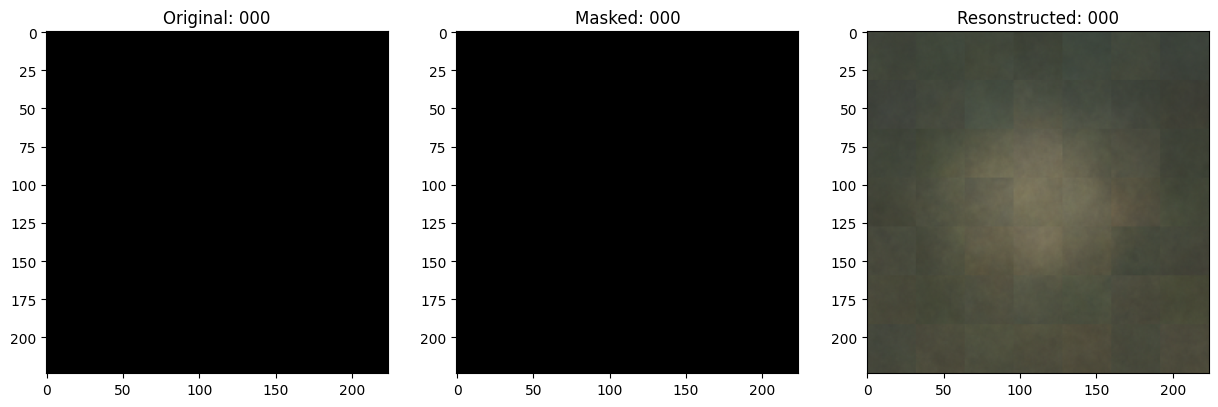

102/102 ━━━━━━━━━━━━━━━━━━━━ 80s 259ms/step - mae: 0.2245 - loss: 0.4113 - val_loss: 0.0017
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 25s 226ms/step - mae: 0.1826 - loss: 0.4420 - val_loss: 0.0017
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 25s 228ms/step - mae: 0.1786 - loss: 0.4459 - val_loss: 0.0017
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 25s 224ms/step - mae: 0.1758 - loss: 0.4485 - val_loss: 0.0016
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 25s 225ms/step - mae: 0.1740 - loss: 0.4504 - val_loss: 0.0017
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - mae: 0.1695 - loss: 0.4564
Idx chosen: 83


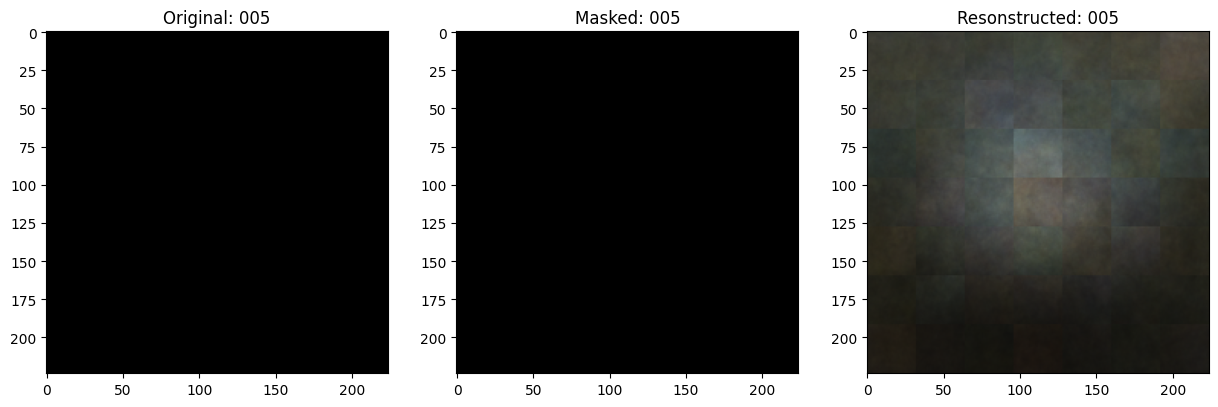

102/102 ━━━━━━━━━━━━━━━━━━━━ 26s 235ms/step - mae: 0.1698 - loss: 0.4565 - val_loss: 0.0017
Epoch 7/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 25s 229ms/step - mae: 0.1661 - loss: 0.4577 - val_loss: 0.0017
Epoch 8/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 25s 227ms/step - mae: 0.1591 - loss: 0.4656 - val_loss: 0.0017
Epoch 9/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 25s 223ms/step - mae: 0.1581 - loss: 0.4655 - val_loss: 0.0017
Epoch 10/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 25s 223ms/step - mae: 0.1550 - loss: 0.4694 - val_loss: 0.0017
Epoch 11/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - mae: 0.1541 - loss: 0.4704
Idx chosen: 96


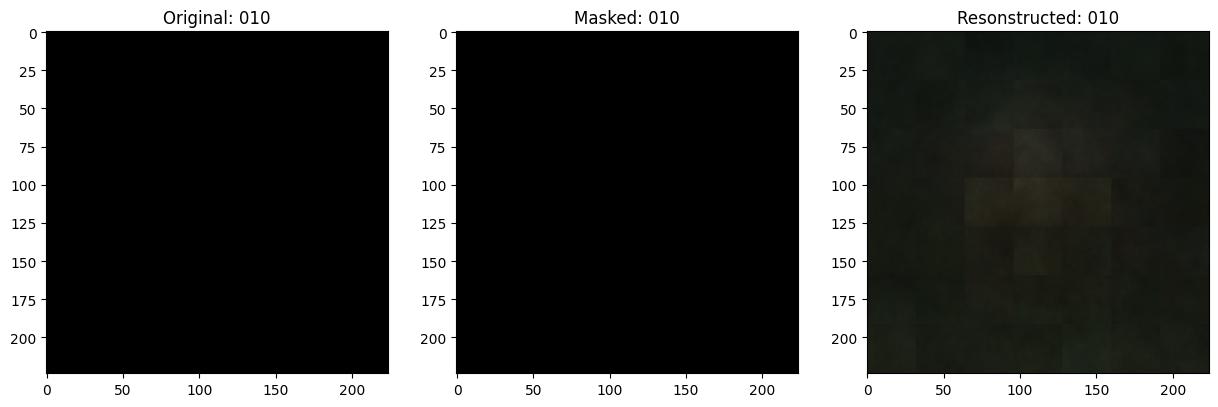

102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 243ms/step - mae: 0.1535 - loss: 0.4705 - val_loss: 0.0016
Epoch 12/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 25s 230ms/step - mae: 0.1530 - loss: 0.4717 - val_loss: 0.0017
Epoch 13/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 25s 225ms/step - mae: 0.1534 - loss: 0.4733 - val_loss: 0.0017
Epoch 14/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 25s 224ms/step - mae: 0.1530 - loss: 0.4717 - val_loss: 0.0017
Epoch 15/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 25s 227ms/step - mae: 0.1525 - loss: 0.4738 - val_loss: 0.0016
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - mae: 0.0972 - loss: 0.0017
{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.0016829853411763906>, 'compile_metrics': {'mae': <tf.Tensor: shape=(), dtype=float32, numpy=0.09725455939769745>}}


In [24]:
#Model compilation and training

optimizer = keras.optimizers.AdamW(
    learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY
)

# Compile and pretrain the model.
mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)
history = mae_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=train_callbacks,
)

# Measure its performance.
results = mae_model.evaluate(test_ds, return_dict=True)
print(results)  # shows all keys and values


In [77]:
# Evaluation with linear probing

In [27]:
#Extract the encoder model along with other layers
# Extract the augmentation layers.
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Swtich the downstream flag to True.

# Extract the encoder.
encoder = mae_model.encoder

# Pack as a model.
downstream_model = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        layers.BatchNormalization(),  # Refer to A.1 (Linear probing).
        layers.GlobalAveragePooling1D(),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="linear_probe_model",
)

# Only the final classification layer of the `downstream_model` should be trainable.
for layer in downstream_model.layers[:-1]:
    layer.trainable = False

downstream_model.summary()

Model: "linear_probe_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ patches_3 (Patches)                  │ (None, 49, 3072)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_encoder_1 (PatchEncoder)       │ (None, 49, 128)             │         399,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mae_encoder (Functional)             │ (None, 49, 128)             │       1,981,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 49, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,383,114 (9.09 MB)

 Trainable params: 1,290 (5.04 KB)

 Non-trainable params: 2,381,824 (9.09 MB)

In [1]:
def prepare_data(images, labels, is_train=True):
    if is_train:
        augmentation_model = train_augmentation_model
    else:
        augmentation_model = test_augmentation_model

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).map(
        lambda x, y: (augmentation_model(x), y), num_parallel_calls=AUTO
    )
    return dataset.prefetch(AUTO)


train_ds = prepare_data(x_train, y_train)
val_ds = prepare_data(x_train, y_train, is_train=False)
test_ds = prepare_data(x_test, y_test, is_train=False)

NameError: name 'x_train' is not defined

In [ ]:
# Perform linear probing
linear_probe_epochs = 50
linear_prob_lr = 0.1
warm_epoch_percentage = 0.1
steps = int((len(x_train) // BATCH_SIZE) * linear_probe_epochs)

warmup_steps = int(steps * warm_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=linear_prob_lr,
    total_steps=steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

optimizer = keras.optimizers.SGD(learning_rate=scheduled_lrs, momentum=0.9)
downstream_model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
downstream_model.fit(train_ds, validation_data=val_ds, epochs=linear_probe_epochs)

loss, accuracy = downstream_model.evaluate(test_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")


In [ ]:
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = downstream_model(images, training=False)
    predicted_labels = tf.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
